# DoWhy: Causal Inference for Software Engineering 

This notebook is for causal effect analysis of different treatments on code completion quality of LLMs in software engineering. Using DoWhy library in Python we analyze the impact of different code completion prompts on the Levenstein distance between the generated code and the ground truth (GT).

Our goal is to **analyze how different code completion prompts might affect the similarity between the generated and original code**. We approach the problem as a Graphical Causal Model-based inference (GCM), which consists of a causal direct acyclic graph (DAG). We show how  the results of this analysis could help improve the LLMs for code completion and understand the impact of prompt emgineering in SWE tasks.

You can download SEMERU datasets at  https://huggingface.co/semeru

Paper where Galeras is introduced: https://arxiv.org/pdf/2308.12415 


### Causal SE Approach Pipeline

Image below illustrates the steps of our analysis pipeline. In this notebook we obtain the data from HuggingFace and perform exploratory data analysis (EDA).  

First, we model cause-effect relationships for each treatment as a Structural Causal Model. 

Second, we identify causal estimand to determine whether a causal effect can be estimated from the available data and causal assumptions. 

Third, we estimate the causal effects of treatments on the outcome, based on the causal estimands identified in the previous step. 

Fourth, we check the robustness and reliability of a causal estimate to determine whether the estimated causal effects could be biased due to data issues, confounding, or assumptions. 



<img src="CausalSE_pipeline.png"  />

Loading the requred libraries. We are using huggingface libraries to download our datasets for software engineering.

In [5]:
from datasets import load_dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from dowhy import CausalModel
import dowhy.datasets
from tabulate import tabulate

import warnings 

# Settings the warnings to be ignored 
warnings.filterwarnings('ignore') 

# Data loading

We load the data from HuggingFace and perform min-max normalization of the Levenshtein distance variable for our analysis. While scaling the variable is not a necessary step, it will ensure that values will be ranging between 0 and 1 for all tratment groups. This will enable us to interpret the outputs of the causal models easily. 


The dataset includes three treatment groups $t\in T$.

- Control template: "Complete the following python method: ```{Random_cut code}```",
- Treatment 1 (T1): "Write a Python method that starts with ```{Function Name}``` , I need to complete this function. Remove comments, summary and descriptions.",
- Treatment 2 (T2): "Remeber you have a Python function named ```{Method Signature}```, the function starts with the following code ```{Random_cut code}```. The description for the function is: ```{docstring}``` remove comments; remove summary; remove description; Return only the code"



In [6]:
dataset = "semeru/causal-se"
data_files="treatments.parquet"

dataset = load_dataset(dataset, cache_dir="../../datax", 
                       revision="main", 
                       data_files=data_files
                       )

dataset.set_format(type='pandas')

# We are using training set configure from Huggingface
treatments_df = dataset['train'][:]

# Normalizing the Levenshtein column
column_to_normalize = 'y_po_lev'

min_value = treatments_df[column_to_normalize].values.min()
max_value = treatments_df[column_to_normalize].values.max()

treatments_df['y_po_lev_norm'] = (treatments_df[column_to_normalize] - min_value) / (max_value - min_value)

print(treatments_df.shape)
treatments_df.sample(3)


(8769, 36)


,commit_id,code,repo,documentation,id,w_n_ast_errors,w_ast_errors,w_vocab_size,d_id,commit_message,...,prediction,e_vocab_size,i_n_whitespaces,i_n_words,template,i_vocab_size,binary_treatment,treatment,y_po_lev,y_po_lev_norm
644,3030fc2f7d414d54a9aaa0f7b47ccf8d4f54b12c,"def precompute_fill_value(dataset_cols, featur...",ludwig,{'docstring': 'Precomputes the fill value for ...,6991,0,,105,1099,Fixes NaN handling in boolean dtypes (#2058)\n...,...,It looks like the code you provided is incompl...,143,428,148,Complete the following python method: ```{}```,101,False,control,507,0.041183
2520,8198943edd73a363c266633e1aa5b2a9e9c9f526,def get_quoted_string(value):\n \n quote...,XX-Net,{'docstring': 'quoted-string = [CFWS] <bare-qu...,223543,0,,17,56962,add python 3.10.4 for windows,...,Here is the complete Python method:\n\n```pyth...,48,89,41,Complete the following python method: ```{}```,23,False,control,228,0.018520
2024,d603d43df2057ecdf74010d9dadc735e37f8f7b5,"def count(self, level=None):\n \n ...",pandas,{'docstring': ' Return number of non-N...,163270,0,,98,39415,TYP: Ignore numpy related issues (#45244),...,Here is the complete Python method:\n\n```pyth...,118,347,102,Complete the following python method: ```{}```,79,False,control,456,0.037040


## Dataset analysis

Boxplot below illustrates that mean for Treatment 1 is higher than for Control group suggesting that T1 increases the Levenshtein distance (the predictions in T1 are less similar to the ground truth that those in control group). Moreover, variance is also slightly higher, leading us to observe that some predictions might deviate more significantly from the ground truth. Hence, it seems like *T1 negatively affects prediction accuracy compare to control*, likely due to differences in the prompt structure.

Conversely, mean and variance of Treatment 2 are lower than those of control group suggesting that T2 decreases the Levenshtein distance and has a more consistent performance. Looking at the boxplot bands, we also observe that the entire distribution of distances shifts downward, suggesting an overall improvement in prediction accuracy. Hence, it seems *T2 improves prediction accuracy compared to control*, likely because we provide more information in the form of docstrings, method signature, and randomly cut code chunks in our T2 prompts.

<Axes: xlabel='treatment', ylabel='y_po_lev_norm'>

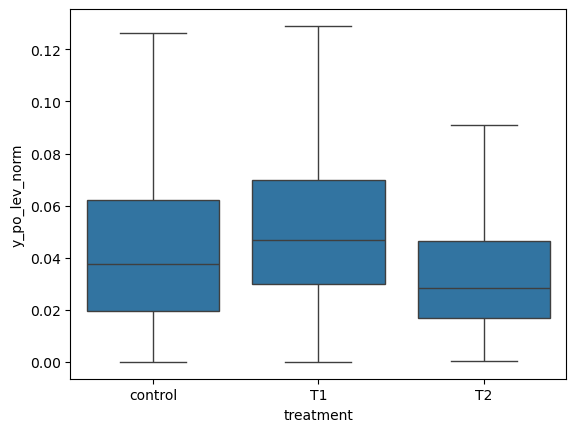

In [29]:
sns.boxplot(data=treatments_df[['y_po_lev_norm','treatment']], x="treatment", y="y_po_lev_norm",showfliers=False)


In [103]:
treatments_df[['y_po_lev_norm','treatment']].groupby('treatment').describe()

y_po_lev_norm                                                    \
                  count      mean       std       min       25%       50%   
treatment                                                                   
T1               2923.0  0.057105  0.047264  0.000000  0.030014  0.046869   
T2               2923.0  0.039820  0.045223  0.000325  0.016692  0.028349   
control          2923.0  0.048084  0.046680  0.000000  0.019738  0.037690   

                               
                75%       max  
treatment                      
T1         0.069653  0.886930  
T2         0.046422  1.000000  
control    0.062343  0.886443

In [92]:
treatments_df[['y_po_lev_norm','binary_treatment']].groupby('binary_treatment').describe()

y_po_lev_norm                                              \
                         count      mean       std  min       25%      50%   
binary_treatment                                                             
False                   2923.0  0.048084  0.046680  0.0  0.019738  0.03769   
True                    5846.0  0.048463  0.047051  0.0  0.022094  0.03704   

                                      
                       75%       max  
binary_treatment                      
False             0.062343  0.886443  
True              0.060109  1.000000

Looking at the boxplot and the statistical summary table above we observe that:

- T1 leads to worse prediction accuracy (higher Levenshtein distance).

- T2 improves prediction accuracy (lower Levenshtein distance).

Potential Reasoning:

- T1’s prompt removes too much information, making it harder for the model to generate accurate completions.

- T2's prompt provides more information in the form of docstrings, method signature, and randomly cut code chunks in our T2 prompts.

This leads us to hypothesize that:

- The closer input prompt size is to the GT, the lower the Levenshtein distance. 

- We expect the following behavior in continues treatments: The more difference lev difference between prompts (i.e. control vs T1, T1 vs T2), the less difference at the potential outcome. We expect a negative correlations or causal effect

### Types of variables used for building the causal graph

***Potential outcomes $Y^t$***: Levenshtaien distance (code predicion, groundtruth), $t\in T$

***Common causes*** are the code snippet ground truth metrics that affect both treatments $T$ and potential outcomes $Y$
- w_ast_levels 
- w_n_whitespaces
- w_complexity
- w_nloc
- w_token_counts
- w_n_ast_nodes


***Instrumental variables*** are the Software Engineering input prompt metrics

- i_n_words
- i_n_whitespaces
- i_vocab_size 

***Effect modifiers*** are the software engineering potential outcome metrics
- e_n_words
- e_n_whitespaces
- e_vocab_size 



As mentioned earlier, we build 3 models per Treatment: one that includes all common cause variables listed above, second one includes an instrumental variable (IV) **i_vocab_size**, and third one includes both IV and effect modifier **e_n_words**. We're modeling three different causal graphs for each treatment because each model accounts for a different set of confounding or modifying factors. We explain each model in more detail later. 

# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Causal Analysis</div>

We rely on the Structural Causal Model (SCM) technique to model our causal inference problem. To achieve this we use Galeras dataset for prompt engineering by SEMERU lab. 

### Causal Effect Inference
1. *Causal model creation:* 
Here we create three causal models (m1, m2, m3) with increasing complexity for each treatment T1 and T2 (total of 6 models). We set a list of confounder (w) variables as |common_causes| and construct a graph. The graph shows all the variables from the dataset represented as nodes and all the causal relationships represented as edges. The arrows on the edges indicate the direction of causality (pointing from the causes to the effects).

    Our variables include (labeled using letters <i, e, w, y> in front of the variable names):

        - Treatment (i) variables that we have manipulated and are the _causes_ in our cause-and-effect relationships.

        - Outcome (e) variables that we measure to identify how they were impcated by the treatment(s) and are the _effects_ in our cause-and-effect relationships.

        - Confounding (w) variables that impact both the treatement and the outcome , wchih create false associations. 

        - Levenstein distance (y) 

    First model (m1) estimates the effects of the confounding variables on the binary treatment variable and the normalized Levenstein's distance. Then the second model (m2) estimates the effect of the treatment variable _i_vocab_size_  in addition to the confounding variables. Lastly, the third model (m3) estimates the effect of the outcome variable _e_n_words_ in addition to the variables from *m2*. e run these models twice for each Treatment set 1 and 2. 

2. *Identifying Causal Estimand:* 
Here we produce estimands to identify the causal effect using instrumental variable method. This method is utlized when unobserved confounding variables might introduce bias to the estimated effect/outcome. 

3. *Causal Effect Estimation:* 
We utilize the Propensity Score Matching, Propensity Score Stratification, and Propensity Score Weighting to estimate the causal effects. 

4. *Validation:* 
We perform a Placebo Treatment and Random Common Cause refutation to validate our results. 

    Analyzing the outputs of the causal model.
    - The instrumental variable method estimates a mean effect of 1071.29 with p-value < 0.001. 

    - The propensity score mathcing method produces mean effect of 9.218

    - The placebo treatment refutation shows a new effect of 1041.10 compaed to the estimated effect of 1071.29 (p-value = 0).
    
    - Correlation analysis between confounding variables shows strong correlation between some variables. For example, w_token_counts and w_n_ast_nodes are strong correlation score of 0.92 for both Pearson and Spearman methods. 


### Treatments

Our baseline (or control) is proving an LLM a randomly cut chunks of code. 

The results for Treatment 1 would help us identify to what extend does providing standardized context impact the code generation outcomes of the LLms.  

The results for Treatment 2 would help us estimate to what extend does providing method signature, randomly cut code chunks, and docstring impact the outputs of the LLMs. 

Overall, the results for both Treatment 1 and Treatment 2 would help us estimate to what extend does prompt engineering impact code generation abilities of LLMs. 


# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Comparing Treatment 1 Vs. Control</div>

### Here we try to estimate how much will the difference between the generated code and ground truth will change if we decide to use prompt Template 1

In [7]:
treatment1 = treatments_df[(treatments_df["treatment"]=="control") | (treatments_df["treatment"]=="T1") ].copy()

### Step-1 Causal graph modeling

##### Model 1: Includes only Common Causes

Here we're establishing a baseline causal effect estimate by controlling for confounders.

This model adjusts for common causes (i.e., pre-existing differences in code complexity, whitespace usage, AST levels, etc.).
The goal is to ensure that any observed effect of treatment on Levenshtein distance (prediction accuracy) is not due to pre-existing differences in these common causes.

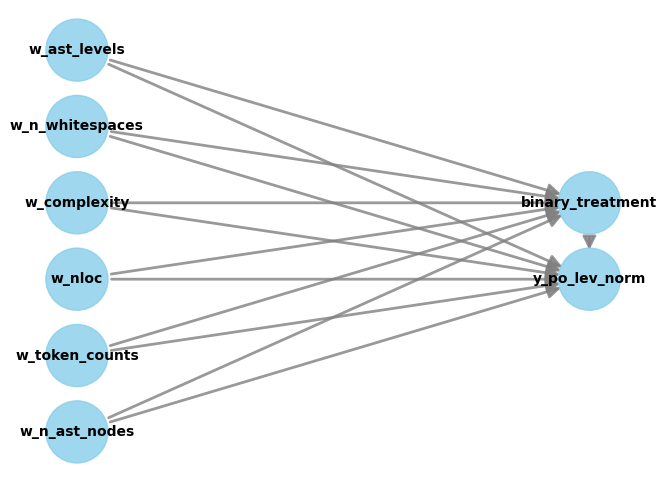

In [52]:
m1 = CausalModel(
        data = treatment1,
        treatment = ['binary_treatment'],
        outcome = ['y_po_lev_norm'],
        common_causes = ['w_ast_levels','w_n_whitespaces','w_complexity','w_nloc','w_token_counts','w_n_ast_nodes']
    )
m1.view_model()

##### Model 2: Includes an Instrumental Variable (IV)

Here we're addressing unobserved confounding using **i_vocab_size** as an IV.

Instrumental variables (IVs) are useful when we suspect there are unmeasured confounders that affect both the treatment and the outcome.
The instrumental variable **i_vocab_size** (size of vocabulary in input prompts) is related to treatment selection but should not directly affect Levenshtein distance except through the treatment.

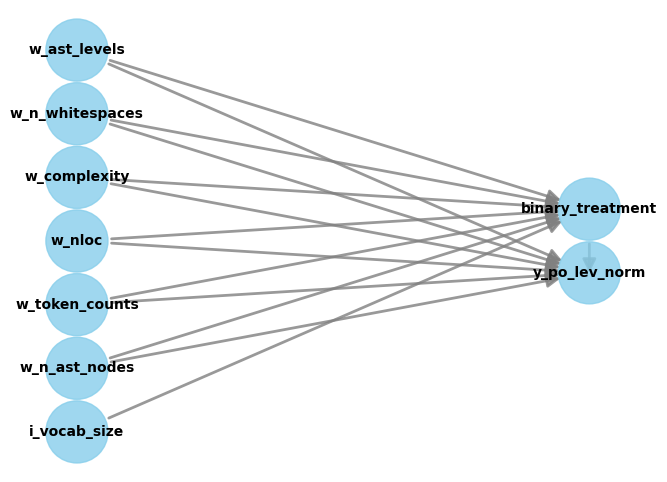

In [53]:
m2 = CausalModel(
        data = treatment1,
        treatment = ['binary_treatment'],
        outcome = ['y_po_lev_norm'],
        common_causes = ['w_ast_levels','w_n_whitespaces','w_complexity','w_nloc','w_token_counts','w_n_ast_nodes'],
        instruments = ['i_vocab_size']
    )
m2.view_model()

##### Model 3: Includes an Effect Modifier

Here we're testing whether treatment effects vary across different subgroups.

Effect modifiers influence the magnitude of the treatment effect, meaning that the effect of treatment is not uniform across different groups.
In this case, **e_n_words** (number of words in the output code) might modify how treatment affects the Levenshtein distance.

Including this variable helps us analyze heterogeneous treatment effects (i.e., does treatment work better for long vs. short responses?)

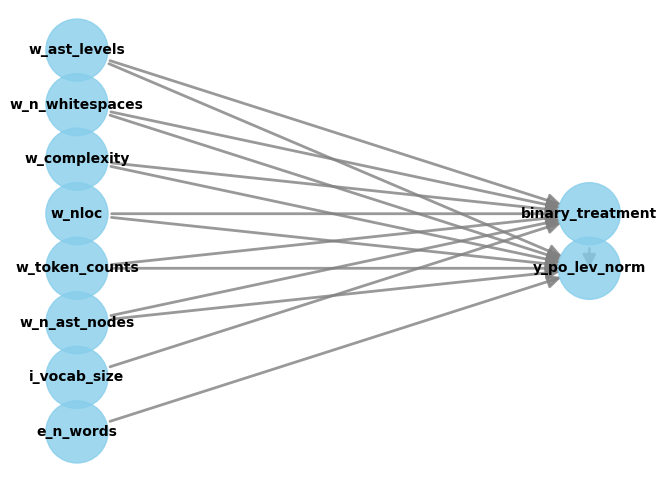

In [56]:
m3 = CausalModel(
        data = treatment1,
        treatment = ['binary_treatment'],
        outcome = ['y_po_lev_norm'],
        common_causes = ['w_ast_levels','w_n_whitespaces','w_complexity','w_nloc','w_token_counts','w_n_ast_nodes'],
        instruments = ['i_vocab_size'],
        effect_modifiers=['e_n_words']
    )
m3.view_model()

### Step-2 Identifiying Causal Estimand

This step of our analysis determines the mathematical expression that represents the causal effect of the treatment on the outcome. It also establishes how the causal effect can be estimated based on the available data and assumptions. Lastly, it identifies whether backdoor, frontdoor, or instrumental variable adjustments are required to remove confounding bias.

In [12]:
# Function to extract relevant details from DoWhy estimand output
def parse_estimand(identified_estimand):
    estimand_str = str(identified_estimand)  # Convert output to string
    estimand_lines = estimand_str.split("\n")  # Split into lines for structured parsing
    
    # Initialize detection flags
    backdoor_found, iv_found, frontdoor_found = False, False, False

    # Iterate through lines to detect if an estimand has an expression
    for i, line in enumerate(estimand_lines):
        if "Estimand name: backdoor" in line:
            backdoor_found = "Estimand expression" in estimand_lines[i + 1] if i + 1 < len(estimand_lines) else False
        elif "Estimand name: iv" in line:
            iv_found = "Estimand expression" in estimand_lines[i + 1] if i + 1 < len(estimand_lines) else False
        elif "Estimand name: frontdoor" in line:
            frontdoor_found = "Estimand expression" in estimand_lines[i + 1] if i + 1 < len(estimand_lines) else False

    return {
        "Estimand Type": str(identified_estimand.estimand_type).lower(),
        "Backdoor": "✅ Found" if backdoor_found else "❌ Not Found",
        "Instrumental Variable (IV)": "✅ Found" if iv_found else "❌ Not Found",
        "Frontdoor": "✅ Found" if frontdoor_found else "❌ Not Found"
    }

In [13]:
# Identify the causal effect
identified_estimand_m1 = m1.identify_effect(proceed_when_unidentifiable=True)
identified_estimand_m2 = m2.identify_effect(proceed_when_unidentifiable=True)
identified_estimand_m3 = m3.identify_effect(proceed_when_unidentifiable=True)

# Parse outputs
m1_results = parse_estimand(identified_estimand_m1)
m2_results = parse_estimand(identified_estimand_m2)
m3_results = parse_estimand(identified_estimand_m3)

# Convert to pandas DataFrame
df = pd.DataFrame([m1_results, m2_results, m3_results], index=["m1", "m2", "m3"])

# Print the table
print(tabulate(df, headers="keys", tablefmt="grid"))



+----+-------------------+------------+------------------------------+--------------+
|    | Estimand Type     | Backdoor   | Instrumental Variable (IV)   | Frontdoor    |
+====+===================+============+==============================+==============+
| m1 | nonparametric-ate | ✅ Found   | ❌ Not Found                 | ❌ Not Found |
+----+-------------------+------------+------------------------------+--------------+
| m2 | nonparametric-ate | ✅ Found   | ✅ Found                     | ❌ Not Found |
+----+-------------------+------------+------------------------------+--------------+
| m3 | nonparametric-ate | ✅ Found   | ✅ Found                     | ❌ Not Found |
+----+-------------------+------------+------------------------------+--------------+


The table shows us that for our first model (m1), only backdoor adjustment is feasible. This indicates that we can estimate the causal effect using observed confounders (which is by design since  we do not include IV and mediators in our m1).

For m2 and m3, both backdoor and instrumental variable (IV) approaches are valid. This suggests that IVs provide an alternative estimation method alongside observed confounders. 

The frontdoor criterion is not satisfied for any model, indicating that an indirect mediating path for causal inference is not available (which is by design since we do not set a mediator parameter in any of our models).

In [14]:
# raw output example
print(identified_estimand_m1)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
──────────────────(E[y_po_lev_norm|w_ast_levels,w_nloc,w_n_whitespaces,w_token
d[binaryₜᵣₑₐₜₘₑₙₜ]                                                            

                                    
_counts,w_complexity,w_n_ast_nodes])
                                    
Estimand assumption 1, Unconfoundedness: If U→{binary_treatment} and U→y_po_lev_norm then P(y_po_lev_norm|binary_treatment,w_ast_levels,w_nloc,w_n_whitespaces,w_token_counts,w_complexity,w_n_ast_nodes,U) = P(y_po_lev_norm|binary_treatment,w_ast_levels,w_nloc,w_n_whitespaces,w_token_counts,w_complexity,w_n_ast_nodes)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Here we have a raw output example of DoWhy function for identifying causal estimand. 

*Estimand expression* is an equation representing the Expected change in Levenshtein distance (scaled), conditioned on our common cause variables under the backdoor criterion. 

*Unconfoundedness* part of the output indicates that if we compare code with the same common cause variable values, we can accurately determine the effect of Binary Treatment on Levenshtein distance without having to worry about the influences of unknown variables. 

### Step-3 Causal effect estimation

This step quantifies the causal effect of treatment on the outcome using the identified estimand. It applies statistical estimation methods (e.g., propensity score methods, instrumental variables) to compute an effect size and assess its significance.

In [15]:
# Function to extract relevant details from DoWhy estimate_effect output
def parse_estimate_effect(estimate_result):
    # Convert output to string
    result_str = str(estimate_result)
    result_lines = result_str.split("\n")  # Split into lines for structured parsing

    # Initialize variables to store relevant information
    estimand_type = None
    estimand_name = None
    mean_value = None
    p_value = None

    # Parse through lines to find the relevant information
    for i, line in enumerate(result_lines):
        if "Estimand type:" in line:
            estimand_type = line.split(":")[1].strip()
        elif "Estimand name:" in line:
            estimand_name = line.split(":")[1].strip()
        elif "Mean value:" in line:
            mean_value = float(line.split(":")[1].strip())
        elif "p-value:" in line:
            # Handle case where p-value is a list (e.g., [0, 0.001])
            p_value_str = line.split(":")[1].strip()
            if "[" in p_value_str and "]" in p_value_str:
                # If p-value is in list format, extract first value
                p_value = float(p_value_str.strip("[]").split(",")[1].strip())
            else:
                # Otherwise, it's a single p-value
                p_value = float(p_value_str)

    return {
        "Estimand Type": estimand_type,
        "Estimand Name": estimand_name,
        "Mean Value": mean_value,
        "P-value": p_value
    }


#### Backdoor

In [16]:
# Estimate the causal effect
estimate_m1_1 = m1.estimate_effect(identified_estimand_m1,
        method_name="backdoor.propensity_score_matching", test_significance=True)

estimate_m1_2 = m1.estimate_effect(identified_estimand_m1,
        method_name="backdoor.propensity_score_stratification", test_significance=True)

estimate_m1_3 = m1.estimate_effect(identified_estimand_m1,
        method_name="backdoor.propensity_score_weighting", test_significance=True)

# Parse the outputs
m1_1_results = parse_estimate_effect(estimate_m1_1)
m1_2_results = parse_estimate_effect(estimate_m1_2)
m1_3_results = parse_estimate_effect(estimate_m1_3)

# Convert to pandas DataFrame
df_estimates = pd.DataFrame([m1_1_results, m1_2_results, m1_3_results],
                            index=["Propensity Score Matching", "Propensity Score Stratification", "Propensity Score Weighting"])

# Print formatted table
print(tabulate(df_estimates, headers="keys", tablefmt="grid"))

propensity_score_matching
propensity_score_stratification
propensity_score_weighting
+---------------------------------+-------------------+-----------------+--------------+-----------+
|                                 | Estimand Type     | Estimand Name   |   Mean Value |   P-value |
+=================================+===================+=================+==============+===========+
| Propensity Score Matching       | nonparametric-ate | backdoor        |   0.00418556 |     0.429 |
+---------------------------------+-------------------+-----------------+--------------+-----------+
| Propensity Score Stratification | nonparametric-ate | backdoor        |   0.00902094 |     0.001 |
+---------------------------------+-------------------+-----------------+--------------+-----------+
| Propensity Score Weighting      | nonparametric-ate | backdoor        |   0.00902094 |     0.001 |
+---------------------------------+-------------------+-----------------+--------------+-----------+


The table above shows us the estimated causal effect size (mean value) and the statistical significance (p-value) for each estimation method we chose (matching, sratification, weighting). 

Based on the mean values under each method, the treatment 1 increases the outcome (distance). On average, the Levenshtein distance for treatment 1 tends to be higher by 0.009 (Stratification) that for control (hence the generated code tends to be less similar to the ground truth).

Based on the p-values, there is no strong evidence of an effect under the Matching (p=0.42) method. However, Stratification & Weighting (p = 0.001) show statistically significant effects, meaning the treatment likely has a real impact.

In [17]:
# raw output example
print(estimate_m1_1)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
──────────────────(E[y_po_lev_norm|w_ast_levels,w_nloc,w_n_whitespaces,w_token
d[binaryₜᵣₑₐₜₘₑₙₜ]                                                            

                                    
_counts,w_complexity,w_n_ast_nodes])
                                    
Estimand assumption 1, Unconfoundedness: If U→{binary_treatment} and U→y_po_lev_norm then P(y_po_lev_norm|binary_treatment,w_ast_levels,w_nloc,w_n_whitespaces,w_token_counts,w_complexity,w_n_ast_nodes,U) = P(y_po_lev_norm|binary_treatment,w_ast_levels,w_nloc,w_n_whitespaces,w_token_counts,w_complexity,w_n_ast_nodes)

## Realized estimand
b: y_po_lev_norm~binary_treatment+w_ast_levels+w_nloc+w_n_whitespaces+w_token_counts+w_complexity+w_n_ast_nodes
Target units: ate

## Estimate
Mean value: 0.0041855572

#### Instrumental Variable (IV)

Only model 2 and 3 had this so we will estimate causal effect for those two models. 

In [18]:
estimate_m2 = m2.estimate_effect(identified_estimand_m2,
        method_name="iv.instrumental_variable", test_significance=True)

estimate_m3 = m3.estimate_effect(identified_estimand_m3,
        method_name="iv.instrumental_variable", test_significance=True)


# Parse the outputs
m2_results = parse_estimate_effect(estimate_m2)
m3_results = parse_estimate_effect(estimate_m3)

# Convert to pandas DataFrame
df_iv_estimates = pd.DataFrame([m2_results, m3_results],
                            index=["Instrumental Variable (IV) for m2", "Instrumental Variable (IV) for m3"])

# Print formatted table
print(tabulate(df_iv_estimates, headers="keys", tablefmt="grid"))

instrumental_variable
instrumental_variable
+-----------------------------------+-------------------+-----------------+--------------+-----------+
|                                   | Estimand Type     | Estimand Name   |   Mean Value |   P-value |
+===================================+===================+=================+==============+===========+
| Instrumental Variable (IV) for m2 | nonparametric-ate | iv              |      0.13919 |     0.001 |
+-----------------------------------+-------------------+-----------------+--------------+-----------+
| Instrumental Variable (IV) for m3 | nonparametric-ate | iv              |      0.13919 |     0.001 |
+-----------------------------------+-------------------+-----------------+--------------+-----------+


Table above shows that under the IV estimation method for both models, there is strong causal effect (mean =0.13919) with high statistical significance (p = 0.001).

In [19]:
# raw output example
print(estimate_m2)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                                                  -1⎤
 ⎢       d                      ⎛       d                          ⎞  ⎥
E⎢───────────────(yₚₒ ₗₑᵥ ₙₒᵣₘ)⋅⎜───────────────([binaryₜᵣₑₐₜₘₑₙₜ])⎟  ⎥
 ⎣d[i_vocab_size]               ⎝d[i_vocab_size]                   ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y_po_lev_norm then ¬(U →→{i_vocab_size})
Estimand assumption 2, Exclusion: If we remove {i_vocab_size}→{binary_treatment}, then ¬({i_vocab_size}→y_po_lev_norm)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
 ⎡      d                    ⎤  -1⎡      d                       ⎤
E⎢─────────────(yₚₒ ₗₑᵥ ₙₒᵣₘ)⎥⋅E  ⎢─────────────(binaryₜᵣₑₐₜₘₑₙₜ)⎥
 ⎣di_vocab_size              ⎦    ⎣di_vocab_size                 ⎦
Estimand assumption 1, As-if-random: If U→→y_po_lev

### Step-4 Validation

This step assesses the robustness and reliability of the estimated causal effect by testing whether the results hold under different assumptions. It uses techniques like placebo tests and adding random confounders to check for hidden biases or spurious correlations in the causal estimation.

##### Refuters

DoWhy provides multiple refutation methods to test the robustness of causal estimates which we use to perform sensitivity tests. 

For each identified estimand we use:
- ***Placebo Treatment Refuter*** which asks "What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable?" As a result of our test we should expect the effect here to be 0.

- ***Random Common Cause Refuter*** which asks "Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset?" As a result of our test we should expect no changes. 

In [ ]:

validaton_placebo_cause_m1_1 = m1.refute_estimate(
                identified_estimand_m1,
                estimate_m1_1,
                method_name="placebo_treatment_refuter",
                placebo_type="permute"
        )

validaton_random_cause_m1_1 = m1.refute_estimate(
                identified_estimand_m1,
                estimate_m1_1,
                method_name="random_common_cause",
                placebo_type="permute"
        )

validaton_placebo_cause_m1_2 = m1.refute_estimate(
                identified_estimand_m1,
                estimate_m1_2,
                method_name="placebo_treatment_refuter",
                placebo_type="permute"
        )


validaton_random_cause_m1_2 = m1.refute_estimate(
                identified_estimand_m1,
                estimate_m1_2,
                method_name="random_common_cause",
                placebo_type="permute"
        )

validaton_placebo_cause_m1_3 = m1.refute_estimate(
                identified_estimand_m1,
                estimate_m1_3,
                method_name="placebo_treatment_refuter",
                placebo_type="permute"
        )

validaton_random_cause_m1_3 = m1.refute_estimate(
                identified_estimand_m1,
                estimate_m1_3,
                method_name="random_common_cause",
                placebo_type="permute"
        )

validaton_placebo_cause_m2 = m2.refute_estimate(
                identified_estimand_m2,
                estimate_m2,
                method_name="placebo_treatment_refuter",
                placebo_type="permute"
        )

validaton_random_cause_m2 = m2.refute_estimate(
                identified_estimand_m2,
                estimate_m2,
                method_name="random_common_cause",
                placebo_type="permute"
        )

validaton_placebo_cause_m3 = m3.refute_estimate(
                identified_estimand_m3,
                estimate_m3,
                method_name="placebo_treatment_refuter",
                placebo_type="permute"
        )

validaton_random_cause_m3 = m3.refute_estimate(
                identified_estimand_m3,
                estimate_m3,
                method_name="random_common_cause",
                placebo_type="permute"
        )

In [ ]:
# Raw output example for refutation 
# Function to extract relevant details from DoWhy refute_estimate output
print(validaton_random_cause_m3.__dict__)

# 
print("Validation results for m3", validaton_random_cause_m3)

{'estimated_effect': 0.13918999545981517, 'new_effect': 0.13918999545981522, 'refutation_type': 'Refute: Add a random common cause', 'refutation_result': {'p_value': 2.0, 'is_statistically_significant': False}, 'refuter': <dowhy.causal_refuters.random_common_cause.RandomCommonCause object at 0x3208715e0>}
Validation results for m3 Refute: Add a random common cause
Estimated effect:0.13918999545981517
New effect:0.13918999545981522
p value:2.0



In [ ]:
# Function to parse refute_estimate outputs
def parse_refute_estimate(refute_result):
    # Access internal fields directly
    estimated_effect = refute_result.estimated_effect
    new_effect = refute_result.new_effect
    refute_method = refute_result.refutation_type
    p_value = None
    is_significant = None

    # Get p-value and significance from the refutation_result dictionary if available
    if hasattr(refute_result, "refutation_result"):
        p_value = refute_result.refutation_result.get("p_value", None)
        is_significant = refute_result.refutation_result.get("is_statistically_significant", None)

    return {
        "Refute Method": refute_method,
        "Estimated Effect": estimated_effect,
        "New Effect": new_effect,
        "p-value": p_value,
        "Stat. Significant": is_significant
    }


In [34]:
# Apply refute_estimate for each validation for m1 and m2 models

# Refutation for m1 (Model 1)
validation_results_m1 = [
    parse_refute_estimate(validaton_placebo_cause_m1_1),
    parse_refute_estimate(validaton_random_cause_m1_1),
    parse_refute_estimate(validaton_placebo_cause_m1_2),
    parse_refute_estimate(validaton_random_cause_m1_2),
    parse_refute_estimate(validaton_placebo_cause_m1_3),
    parse_refute_estimate(validaton_random_cause_m1_3)
]

# Refutation for m2 (Model 2)
validation_results_m2 = [
    parse_refute_estimate(validaton_placebo_cause_m2),
    parse_refute_estimate(validaton_random_cause_m2)
]

# Refutation for m3 (Model 3)
validation_results_m3 = [
    parse_refute_estimate(validaton_placebo_cause_m3),
    parse_refute_estimate(validaton_random_cause_m3)
]

# Combine all results into a dataframe for easier visualization

# Convert the results into pandas DataFrames
df_refute_m1 = pd.DataFrame(validation_results_m1, 
                             index=["Placebo 1 (m1)", "Random Cause 1 (m1)", "Placebo 2 (m1)", "Random Cause 2 (m1)", 
                                    "Placebo 3 (m1)", "Random Cause 3 (m1)"])

df_refute_m2 = pd.DataFrame(validation_results_m2, 
                             index=["Placebo (m2)", "Random Cause (m2)"])

df_refute_m3 = pd.DataFrame(validation_results_m3, 
                             index=["Placebo (m3)", "Random Cause (m3)"])

# Merge the DataFrames (if you want both m1 and m2 results in a single table)
df_refute_all = pd.concat([df_refute_m1, df_refute_m2, df_refute_m3], axis=0)

# Print the resulting table
print(tabulate(df_refute_all, headers="keys", tablefmt="grid"))


+---------------------+-----------------------------------+--------------------+--------------+-----------+---------------------+
|                     | Refute Method                     |   Estimated Effect |   New Effect |   p-value | Stat. Significant   |
+=====================+===================================+====================+==============+===========+=====================+
| Placebo 1 (m1)      | Refute: Use a Placebo Treatment   |         0.00418556 | -6.87662e-05 |      0.94 | False               |
+---------------------+-----------------------------------+--------------------+--------------+-----------+---------------------+
| Random Cause 1 (m1) | Refute: Add a random common cause |         0.00418556 |  0.00903027  |      0.06 | False               |
+---------------------+-----------------------------------+--------------------+--------------+-----------+---------------------+
| Placebo 2 (m1)      | Refute: Use a Placebo Treatment   |         0.00902094 |  7.78005e

The table above shows us the Estimated Effect, New Effect, and p-value for each refutation method. Here we will explain only few: Pleacebo and Random Common Cause Refutation for the estimated effect caluslated with Propensity score matching and Straitification. 

For Placebo 1 (m1), the new effect (-0.000132248) is somewhat different from the estimated effect (0.00418556), but the high p-value (0.94) indicates that this difference is not statistically significant. This suggests that introducing a placebo treatment does not meaningfully alter the estimated effect, supporting the robustness of our causal inference.

For Random Cause 1 (m1), the new effect (0.00898435) is notably larger than the estimated effect (0.00418556), and the low p-value (0.02) suggests a statistically significant difference. This indicates that adding a random common cause affects the estimated effect, implying potential sensitivity to unobserved confounders.

For Placebo 2 (m1), the new effect (8.79337e-05) is lower than the estimated effect (0.00902094), but the high p-value (0.8) suggests that this difference is not statistically significant. This means that introducing a placebo treatment does not meaningfully alter the estimated effect, reinforcing the robustness of our causal inference.

For Random Cause 2 (m1), the new effect (0.00905529) is very close to the estimated effect (0.00902094), and the high p-value (0.8) indicates no statistically significant difference. This suggests that adding a random common cause does not substantially affect the estimated effect, increasing confidence in the validity of our causal model.

# <div style="border-radius:10px; border:#E75480 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:center">Comparing Treatment 2 Vs. Control</div>

#### Here we try to estimate how much will the difference between the generated code and ground truth will change if we decide to use prompt Template 2

In [70]:
treatment2 = treatments_df[(treatments_df["treatment"]=="control") | (treatments_df["treatment"]=="T2") ].copy()

### Step-2 Causal graph modeling

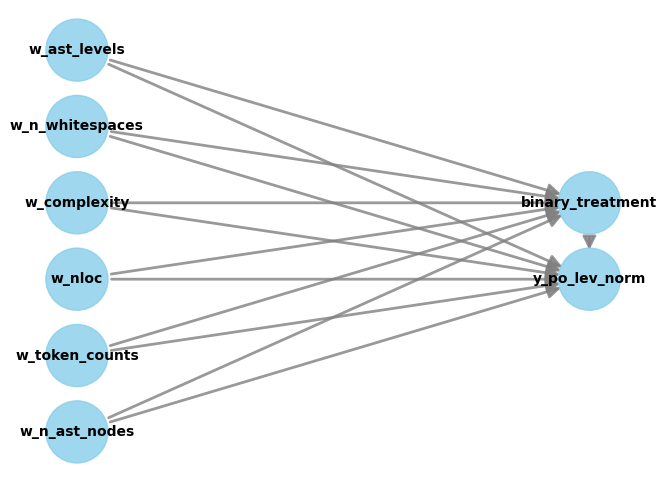

In [27]:
m1 = CausalModel(
        data = treatment2,
        treatment = ['binary_treatment'],
        outcome = ['y_po_lev_norm'],
        common_causes = ['w_ast_levels','w_n_whitespaces','w_complexity','w_nloc','w_token_counts','w_n_ast_nodes']
    )
m1.view_model()

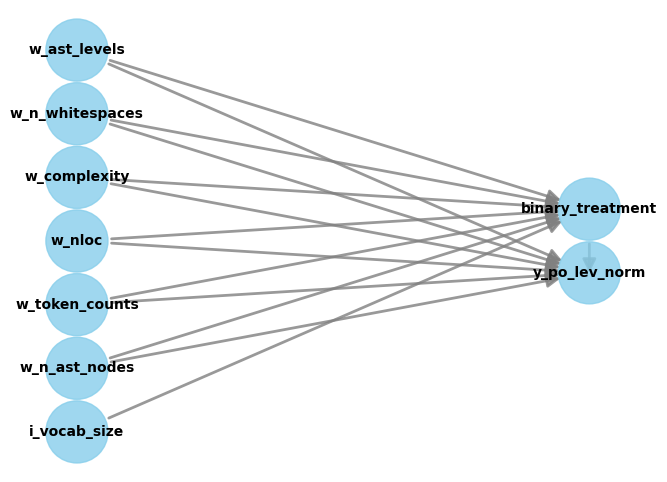

In [28]:
m2 = CausalModel(
        data = treatment2,
        treatment = ['binary_treatment'],
        outcome = ['y_po_lev_norm'],
        common_causes = ['w_ast_levels','w_n_whitespaces','w_complexity','w_nloc','w_token_counts','w_n_ast_nodes'],
        instruments = ['i_vocab_size']
    )
m2.view_model()

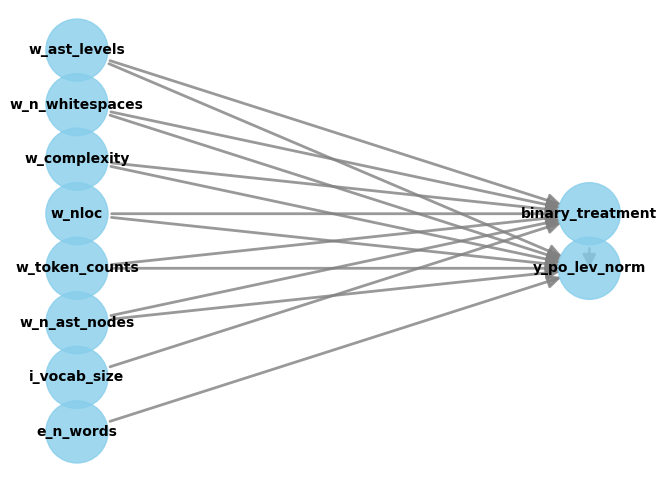

In [29]:
m3 = CausalModel(
        data = treatment2,
        treatment = ['binary_treatment'],
        outcome = ['y_po_lev_norm'],
        common_causes = ['w_ast_levels','w_n_whitespaces','w_complexity','w_nloc','w_token_counts','w_n_ast_nodes'],
        instruments = ['i_vocab_size'],
        effect_modifiers=['e_n_words']
    )
m3.view_model()

### Step-2 Identifiying Causal Estimand

In [76]:
# Identify the causal effect
identified_estimand_m1 = m1.identify_effect(proceed_when_unidentifiable=True)
identified_estimand_m2 = m2.identify_effect(proceed_when_unidentifiable=True)
identified_estimand_m3 = m3.identify_effect(proceed_when_unidentifiable=True)

# Parse outputs
m1_results = parse_estimand(identified_estimand_m1)
m2_results = parse_estimand(identified_estimand_m2)
m3_results = parse_estimand(identified_estimand_m3)

# Convert to pandas DataFrame
df = pd.DataFrame([m1_results, m2_results, m3_results], index=["m1", "m2", "m3"])

# Print the table
print(tabulate(df, headers="keys", tablefmt="grid"))

+----+-------------------+------------+------------------------------+--------------+
|    | Estimand Type     | Backdoor   | Instrumental Variable (IV)   | Frontdoor    |
+====+===================+============+==============================+==============+
| m1 | nonparametric-ate | ✅ Found   | ❌ Not Found                 | ❌ Not Found |
+----+-------------------+------------+------------------------------+--------------+
| m2 | nonparametric-ate | ✅ Found   | ✅ Found                     | ❌ Not Found |
+----+-------------------+------------+------------------------------+--------------+
| m3 | nonparametric-ate | ✅ Found   | ✅ Found                     | ❌ Not Found |
+----+-------------------+------------+------------------------------+--------------+


In [78]:
# raw output example
print(identified_estimand_m1)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
──────────────────(E[y_po_lev_norm|w_token_counts,w_complexity,w_nloc,w_n_whit
d[binaryₜᵣₑₐₜₘₑₙₜ]                                                            

                                    
espaces,w_n_ast_nodes,w_ast_levels])
                                    
Estimand assumption 1, Unconfoundedness: If U→{binary_treatment} and U→y_po_lev_norm then P(y_po_lev_norm|binary_treatment,w_token_counts,w_complexity,w_nloc,w_n_whitespaces,w_n_ast_nodes,w_ast_levels,U) = P(y_po_lev_norm|binary_treatment,w_token_counts,w_complexity,w_nloc,w_n_whitespaces,w_n_ast_nodes,w_ast_levels)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Step-3 Causal effect estimation

In [81]:
# Estimate the causal effect
estimate_m1_1 = m1.estimate_effect(identified_estimand_m1,
        method_name="backdoor.propensity_score_matching", test_significance=True)

estimate_m1_2 = m1.estimate_effect(identified_estimand_m1,
        method_name="backdoor.propensity_score_stratification", test_significance=True)

estimate_m1_3 = m1.estimate_effect(identified_estimand_m1,
        method_name="backdoor.propensity_score_weighting", test_significance=True)

# Parse the outputs
m1_1_results = parse_estimate_effect(estimate_m1_1)
m1_2_results = parse_estimate_effect(estimate_m1_2)
m1_3_results = parse_estimate_effect(estimate_m1_3)

# Convert to pandas DataFrame
df_estimates = pd.DataFrame([m1_1_results, m1_2_results, m1_3_results],
                            index=["Propensity Score Matching", "Propensity Score Stratification", "Propensity Score Weighting"])

# Print formatted table
print(tabulate(df_estimates, headers="keys", tablefmt="grid"))

propensity_score_matching
propensity_score_stratification
propensity_score_weighting
+---------------------------------+-------------------+-----------------+--------------+-----------+
|                                 | Estimand Type     | Estimand Name   |   Mean Value |   P-value |
+=================================+===================+=================+==============+===========+
| Propensity Score Matching       | nonparametric-ate | backdoor        |  -0.00977759 |     0.286 |
+---------------------------------+-------------------+-----------------+--------------+-----------+
| Propensity Score Stratification | nonparametric-ate | backdoor        |  -0.00826446 |     0.001 |
+---------------------------------+-------------------+-----------------+--------------+-----------+
| Propensity Score Weighting      | nonparametric-ate | backdoor        |  -0.00826446 |     0.001 |
+---------------------------------+-------------------+-----------------+--------------+-----------+


In [83]:
# raw output example
print(estimate_m1_1)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                                                     
──────────────────(E[y_po_lev_norm|w_token_counts,w_complexity,w_nloc,w_n_whit
d[binaryₜᵣₑₐₜₘₑₙₜ]                                                            

                                    
espaces,w_n_ast_nodes,w_ast_levels])
                                    
Estimand assumption 1, Unconfoundedness: If U→{binary_treatment} and U→y_po_lev_norm then P(y_po_lev_norm|binary_treatment,w_token_counts,w_complexity,w_nloc,w_n_whitespaces,w_n_ast_nodes,w_ast_levels,U) = P(y_po_lev_norm|binary_treatment,w_token_counts,w_complexity,w_nloc,w_n_whitespaces,w_n_ast_nodes,w_ast_levels)

## Realized estimand
b: y_po_lev_norm~binary_treatment+w_token_counts+w_complexity+w_nloc+w_n_whitespaces+w_n_ast_nodes+w_ast_levels
Target units: ate

## Estimate
Mean value: -0.009777587

#### Instrumental Variable (IV)

Since only models 2 and 3 have this estimand type we will calculate the causal effect for those two models.

In [123]:
estimate_m2 = m2.estimate_effect(identified_estimand_m2,
        method_name="iv.instrumental_variable", test_significance=True)

estimate_m3 = m3.estimate_effect(identified_estimand_m3,
        method_name="iv.instrumental_variable", test_significance=True)


# Parse the outputs
m2_results = parse_estimate_effect(estimate_m2)
m3_results = parse_estimate_effect(estimate_m3)

# Convert to pandas DataFrame
df_iv_estimates = pd.DataFrame([m2_results, m3_results],
                            index=["Instrumental Variable (IV) for m2", "Instrumental Variable (IV) for m3"])

# Print formatted table
print(tabulate(df_iv_estimates, headers="keys", tablefmt="grid"))

instrumental_variable
instrumental_variable
+-----------------------------------+-------------------+-----------------+--------------+-----------+
|                                   | Estimand Type     | Estimand Name   |   Mean Value |   P-value |
+===================================+===================+=================+==============+===========+
| Instrumental Variable (IV) for m2 | nonparametric-ate | iv              |      0.13919 |     0.001 |
+-----------------------------------+-------------------+-----------------+--------------+-----------+
| Instrumental Variable (IV) for m3 | nonparametric-ate | iv              |      0.13919 |     0.001 |
+-----------------------------------+-------------------+-----------------+--------------+-----------+


In [84]:
# raw output example
print(estimate_m2)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: iv
Estimand expression:
 ⎡                                                                  -1⎤
 ⎢       d                      ⎛       d                          ⎞  ⎥
E⎢───────────────(yₚₒ ₗₑᵥ ₙₒᵣₘ)⋅⎜───────────────([binaryₜᵣₑₐₜₘₑₙₜ])⎟  ⎥
 ⎣d[i_vocab_size]               ⎝d[i_vocab_size]                   ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y_po_lev_norm then ¬(U →→{i_vocab_size})
Estimand assumption 2, Exclusion: If we remove {i_vocab_size}→{binary_treatment}, then ¬({i_vocab_size}→y_po_lev_norm)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: nonparametric-ate
Estimand expression:
 ⎡      d                    ⎤  -1⎡      d                       ⎤
E⎢─────────────(yₚₒ ₗₑᵥ ₙₒᵣₘ)⎥⋅E  ⎢─────────────(binaryₜᵣₑₐₜₘₑₙₜ)⎥
 ⎣di_vocab_size              ⎦    ⎣di_vocab_size                 ⎦
Estimand assumption 1, As-if-random: If U→→y_po_lev

### Step-4 Validation

##### Refuters

DoWhy provides multiple refutation methods to test the robustness of causal estimates which we use to perform sensitivity tests. 

For models 2 and 3, Placebo Treatment Refuter was producing invalid results leading us to replace it with Data Subsample Refuter.

- ***Data Subsample Refuter*** asks "Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset?" As a result of our test we should expect no changes.

In [ ]:
validaton_placebo_cause_m1_1 = m1.refute_estimate(
                identified_estimand_m1,
                estimate_m1_1,
                method_name="placebo_treatment_refuter",
                placebo_type="permute"
        )

validaton_random_cause_m1_1 = m1.refute_estimate(
                identified_estimand_m1,
                estimate_m1_1,
                method_name="random_common_cause",
                placebo_type="permute"
        )

validaton_placebo_cause_m1_2 = m1.refute_estimate(
                identified_estimand_m1,
                estimate_m1_2,
                method_name="placebo_treatment_refuter",
                placebo_type="permute"
        )


validaton_random_cause_m1_2 = m1.refute_estimate(
                identified_estimand_m1,
                estimate_m1_2,
                method_name="random_common_cause",
                placebo_type="permute"
        )

validaton_placebo_cause_m1_3 = m1.refute_estimate(
                identified_estimand_m1,
                estimate_m1_3,
                method_name="placebo_treatment_refuter",
                placebo_type="permute"
        )

validaton_random_cause_m1_3 = m1.refute_estimate(
                identified_estimand_m1,
                estimate_m1_3,
                method_name="random_common_cause",
                placebo_type="permute"
        )

validaton_subset_cause_m2 = m2.refute_estimate(
    identified_estimand_m2,
    estimate_m2,
    method_name="data_subset_refuter"
)


validaton_random_cause_m2 = m2.refute_estimate(
                identified_estimand_m2,
                estimate_m2,
                method_name="random_common_cause",
                placebo_type="permute"
        )

validaton_subset_cause_m3 = m3.refute_estimate(
                identified_estimand_m3,
                estimate_m3,
                method_name="data_subset_refuter",
                placebo_type="permute"
        )

validaton_random_cause_m3 = m3.refute_estimate(
                identified_estimand_m3,
                estimate_m3,
                method_name="random_common_cause",
                placebo_type="permute"
        )



In [90]:
# Apply refute_estimate for each validation for m1 and m2 models

# Refutation for m1 (Model 1)
validation_results_m1 = [
    parse_refute_estimate(validaton_placebo_cause_m1_1),
    parse_refute_estimate(validaton_random_cause_m1_1),
    parse_refute_estimate(validaton_placebo_cause_m1_2),
    parse_refute_estimate(validaton_random_cause_m1_2),
    parse_refute_estimate(validaton_placebo_cause_m1_3),
    parse_refute_estimate(validaton_random_cause_m1_3)
]

# Refutation for m2 (Model 2)
validation_results_m2 = [
    parse_refute_estimate(validaton_subset_cause_m2),
    parse_refute_estimate(validaton_random_cause_m2)
]

# Refutation for m3 (Model 3)
validation_results_m3 = [
    parse_refute_estimate(validaton_subset_cause_m3),
    parse_refute_estimate(validaton_random_cause_m3)
]

# Combine all results into a dataframe for easier visualization

# Convert the results into pandas DataFrames
df_refute_m1 = pd.DataFrame(validation_results_m1, 
                             index=["Placebo 1 (m1)", "Random Cause 1 (m1)", "Placebo 2 (m1)", "Random Cause 2 (m1)", 
                                    "Placebo 3 (m1)", "Random Cause 3 (m1)"])

df_refute_m2 = pd.DataFrame(validation_results_m2, 
                             index=["Subset (m2)", "Random Cause (m2)"])

df_refute_m3 = pd.DataFrame(validation_results_m3, 
                             index=["Subset (m3)", "Random Cause (m3)"])

# Merge the DataFrames (if you want both m1 and m2 results in a single table)
df_refute_all = pd.concat([df_refute_m1, df_refute_m2, df_refute_m3], axis=0)

# Print the resulting table
print(tabulate(df_refute_all, headers="keys", tablefmt="grid"))

+---------------------+-----------------------------------+--------------------+--------------+-----------+
|                     | Refute Method                     |   Estimated Effect |   New Effect |   p-value |
+=====================+===================================+====================+==============+===========+
| Placebo 1 (m1)      | Refute: Use a Placebo Treatment   |        -0.00977759 | -6.8591e-05  |      1    |
+---------------------+-----------------------------------+--------------------+--------------+-----------+
| Random Cause 1 (m1) | Refute: Add a random common cause |        -0.00977759 | -0.00823389  |      0.04 |
+---------------------+-----------------------------------+--------------------+--------------+-----------+
| Placebo 2 (m1)      | Refute: Use a Placebo Treatment   |        -0.00826446 |  6.78222e-05 |      0.82 |
+---------------------+-----------------------------------+--------------------+--------------+-----------+
| Random Cause 2 (m1) | Refu

### Exploratory Data Analysis

In [106]:
documentation_df = pd.concat([treatments_df['id'], treatments_df['code'], treatments_df['documentation'].apply(pd.Series)], axis=1)
print(documentation_df.shape)
documentation_df.sample(3)


(8769, 7)


,id,code,docstring,language,n_whitespaces,n_words,vocab_size
3083,182049,"def enable_application_mode() -> Callable[[], ...",Enable application mode.\n\n Returns:\n ...,en,28,15,15
5419,132825,"def delete_checkpoint(self, checkpoint_path):\...",Deletes local copy of checkpoint.\n\n A...,en,36,11,10
8632,191358,def test_does_not_allow_extra_kwargs() -> None...,Test formatting does not allow extra key word ...,en,8,9,9


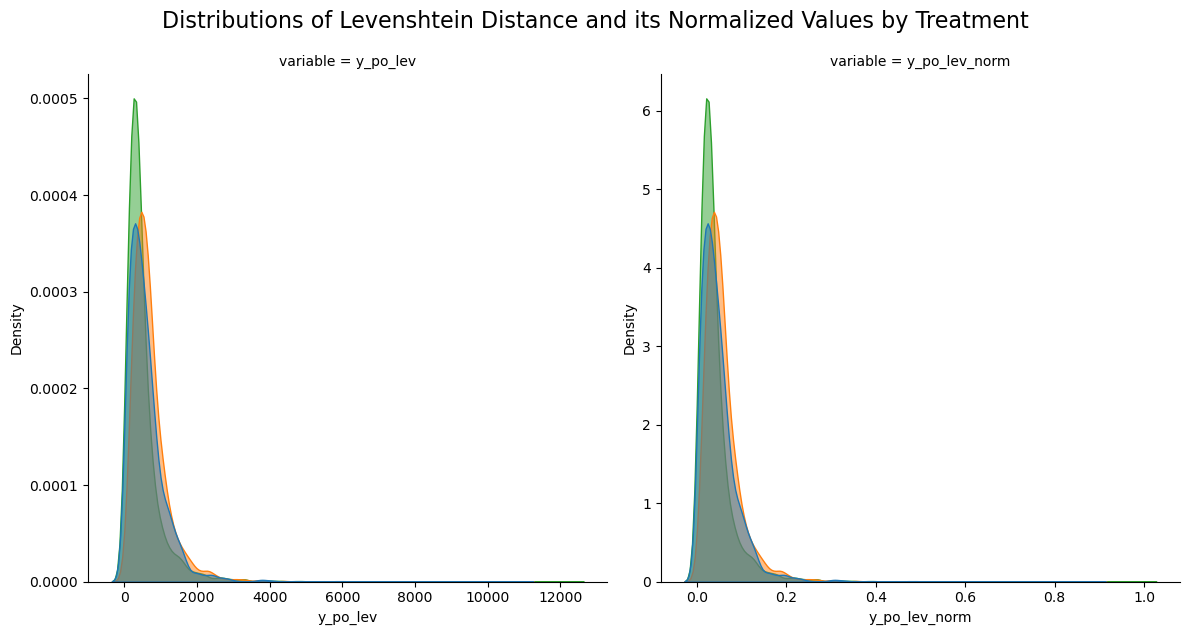

In [98]:

# Melt the dataframe first to combine `y_po_lev_norm` and `y_po_lev` into one column
melted_df = treatments_df.melt(
    id_vars=["treatment"],  # Columns to keep (e.g., `treatment`)
    value_vars=["y_po_lev", "y_po_lev_norm"],  # Columns to melt
    var_name="variable",  # New column name for variables
    value_name="value"  # New column name for values
)

# Initialize the FacetGrid with larger size
g = sns.FacetGrid(
    melted_df, 
    col="variable", 
    sharex=False, 
    sharey=False, 
    height=6,  # Height of each subplot
    aspect=1  # Width-to-height ratio
)

# Map the KDE plot to the grid
g.map_dataframe(
    sns.kdeplot,
    x="value",
    hue="treatment",
    fill=True,
    alpha=0.5
)

# Add variable names as x-axis labels
for ax, variable in zip(g.axes.flat, melted_df["variable"].unique()):
    ax.set_xlabel(variable)  # Set the x-axis label to the variable name

# Add an overall title
g.fig.suptitle("Distributions of Levenshtein Distance and its Normalized Values by Treatment", 
               y=1.05, fontsize=16)


# Show the plot
plt.show()


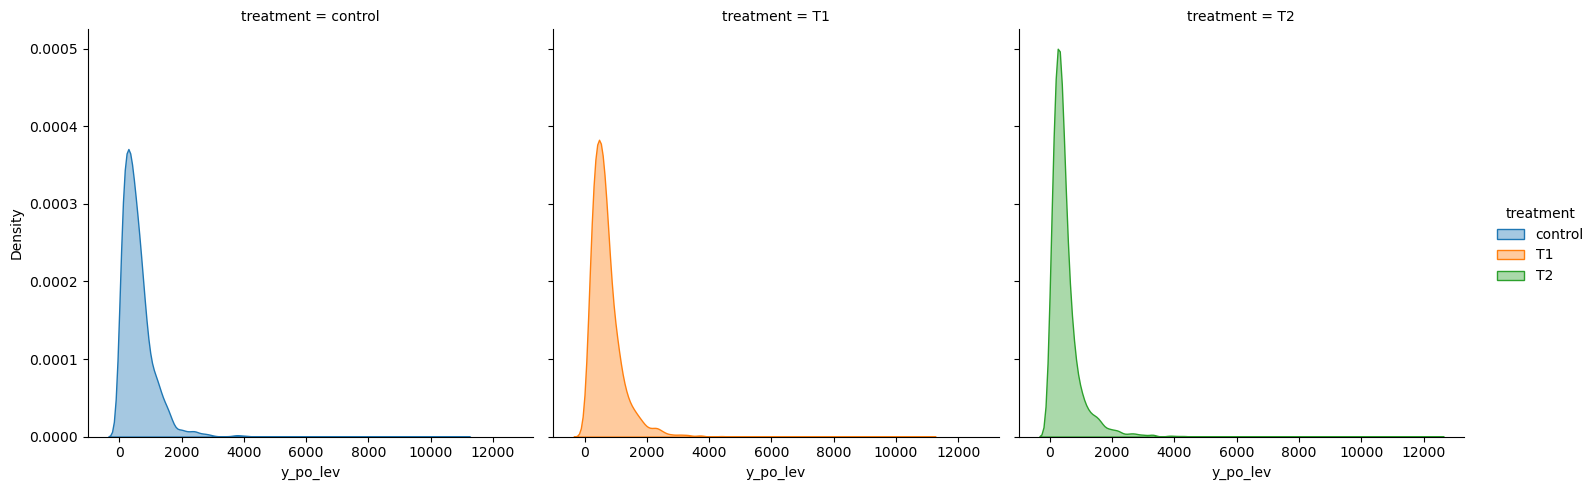

In [95]:
sns.displot(treatments_df, x="y_po_lev", hue="treatment", kind="kde", fill=True, alpha=0.4, col="treatment")


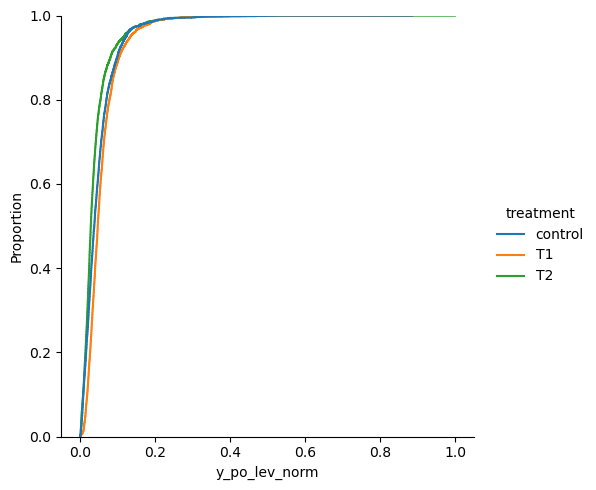

In [99]:
sns.displot(treatments_df, x="y_po_lev_norm", hue="treatment", kind="ecdf")

Developer experience,
Demographic info
machine generated? 
Is a code debug?

- [] dependent and independent cofounders
- [ ] compute cofounders correlation

- Model parameters
- Loss prediction
- Sampling
